In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

import time

In [2]:
def benchmark(f, n: int or float = 10e5, args: tuple = None, kwargs: dict = None) -> np.array:
    if args is None:
        args = ()
    if kwargs is None:
        kwargs = {}
    
    start = time.process_time()
    for _ in range(int(n)):
        f(*args, **kwargs)
    end = time.process_time()
    return (end - start)/n

In [3]:
def test_matmul(f):
    A = np.random.rand(10,2)
    B = np.random.rand(2,5)
    C = np.zeros((A.shape[0], B.shape[1]))
    f(A, B, C)
    return np.max(np.abs(np.dot(A, B) - C))

def benchmark_matmul(f, Ns, n):
    times = []
    for N in Ns:
        A = np.random.rand(N,N)
        B = np.random.rand(N,N)
        C = np.zeros((N, N))
        times.append(benchmark(f, n, args=(A, B, C)))
    return times

In [4]:
def laplas_1(U, D, h=1):
    K, J = U.shape
    
    for k in range(K):
        for j in range(J):
            D[k,j] = (U[(k-1) % K,j%J] + U[(k+1) % K,j % J] - 4*U[k%K,j%J] + U[k%K,(j+1)%J]+U[k%K,(j-1)%J])/h

In [5]:
A = np.random.rand(2,2)
ind = np.arange(2)
A

array([[0.4582257 , 0.94901556],
       [0.50481571, 0.4875605 ]])

In [6]:
A[ind, 1]

array([0.94901556, 0.4875605 ])

In [7]:
A[ind, ind]

array([0.4582257, 0.4875605])

In [8]:
A[ind]

array([[0.4582257 , 0.94901556],
       [0.50481571, 0.4875605 ]])

In [10]:
(11) % 10

1

In [11]:
U = np.eye(3)
D = np.zeros((3,3))
laplas_1(U,D)

In [12]:
D

array([[-4.,  2.,  2.],
       [ 2., -4.,  2.],
       [ 2.,  2., -4.]])

In [13]:
def create_D(D, N=3, M=3):
    pattern_1 = np.zeros((M,M))
    pattern_1[0,0] = -4
    pattern_1[0,1] = 1
    pattern_1[0,-1] = 1
    for n in range(M-1):
        pattern_1[n+1] = np.roll(pattern_1[0],n+1)

    pattern_2 = np.eye(M,M)
    pattern_2
    
    for n in range(N):
        D[M*n:M*(n+1),M*n:M*(n+1)] = pattern_1
        for m in range(M):
            D[M*n+m, (M*(n+1)+m) % (M*N)] = 1
            D[M*n+m, (M*(n+2)+m) % (M*N)] = 1

N, M = 3, 3
D = np.zeros((N*M,N*M))
create_D(D,N,M)
D

array([[-4.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.],
       [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  1.,  0.],
       [ 1.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  0., -4.,  1.,  1.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  1.,  1., -4.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  1.],
       [ 0.,  1.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  1.,  1., -4.]])

In [22]:
def create_D_slice(D, N=3, M=3):
    D.reshape((N,M,N,M))
    diag_ind = np.arange(N*M)
#     up_diag = diag_ind[]
    D[diag_ind, diag_ind] = -4
    D[diag_ind[:-1], diag_ind[1:]] = 1
    D[diag_ind[1:], diag_ind[:-1]] = 1
#     for i in range(N):
        
#     D[diag_ind, M:M*N:M] =1
    
N, M = 3, 3
D = np.zeros((N*M,N*M))
create_D_slice(D,N,M)
D

array([[-4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -4.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -4.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -4.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -4.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -4.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -4.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -4.]])

In [153]:
N, M = 10,10
D = np.zeros((N*M,N*M))
benchmark(create_D, n=10e3, kwargs={'D': D, 'N':N,'M':M})

0.000165625

In [102]:
D = np.zeros((N,N,M,M))
def create_D_4D(D, N=3, M=3):
    diag_N = np.arange(N)
    diag_M = np.arange(M)
    D[diag_N, diag_N][:, 1,1] = -4
#     D[diag_N, diag_N, 1,1] = -4

create_D_4D(D)
# D.reshape(N*M,N*M,)
D

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]])

In [289]:
def laplas_simple(u, L, h=1):
    K, J = u.shape
    for k in range(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2

u = np.eye(9)
L = np.zeros_like(u)
laplas(u, L)
L

N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas, n=5, args=(u, L, 1)))

for + jit  1.678125


In [291]:
benchmark(lambda: u*4, n=10)

0.2859375

In [288]:
@nb.njit(parallel=True)
def laplas(u, L, h=1):
    K, J = u.shape
    for k in nb.prange(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2

u = np.eye(9)
L = np.zeros_like(u)
laplas(u, L)
L

N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas, n=5, args=(u, L, 1)))

for + jit  1.778125


In [177]:
def laplas_2(u, L, h=1):
    K, J = u.shape
    ind_K = np.arange(K)
    ind_J = np.arange(J)
    
    L[:,:] = (u[(ind_K+1) % K,:] + u[(ind_K-1) % K,:] -4*u[:,:] + u[:,(ind_J-1) % J] + u[:,(ind_J+1) % J])/h**2
    

u = np.eye(9)
L = np.zeros_like(u)
laplas(u, L)
L

array([[-4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 2., -4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2., -4.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2., -4.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2., -4.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2., -4.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2., -4.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2., -4.,  2.],
       [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  2., -4.]])

In [178]:
def laplas_3(u, L, h=1):
    K, J = u.shape
    ind_K = np.arange(K)
    ind_J = np.arange(J)
    
    L[:,:] = (u.take((ind_K+1) % K, axis=0) + u.take((ind_K-1) % K, axis=0) -4* u[:,:] + u.take((ind_J-1) % J, axis=1) + u.take((ind_J+1) % J, axis=1))/h**2
    

u = np.eye(9)
L = np.zeros_like(u)
laplas(u, L)
L

array([[-4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.],
       [ 2., -4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  2., -4.,  2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2., -4.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  2., -4.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2., -4.,  2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  2., -4.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2., -4.,  2.],
       [ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  2., -4.]])

In [4]:
@nb.njit('void(f8[:,::1],f8[:,::1],f8)' )
def laplas_no_bc(u, L, h):
    K, J = u.shape
    i = 1/h**2
    for k in nb.prange(1, K-1):
        for j in range(1, J-1):
            L[k,j] = (u[(k+1),j]+u[(k-1),j]-4*u[k,j]+u[k,(j+1)]+u[k,(j-1)]) * i
        
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas_no_bc, n=5, args=(u, L, 1)))

for + jit  0.3125


In [5]:
@nb.njit('void(f8[:,::1],f8[:,::1],f8)')
def laplas_4(u, L, h):
    K, J = u.shape
    for k in nb.prange(1,K-1):
        for j in range(1,J-1):
#             L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            L[k,j] = (u[(k+1),j]+u[(k-1),j]-4*u[k,j]+u[k,(j+1)]+u[k,(j-1)])
    
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas_4, n=5, args=(u, L, 1)))

for + jit  0.809375


In [35]:
nb.set_num_threads(1)

@nb.njit('void(f8[:,::1],f8[:,::1],f8)', nogil=True, parallel=True)
def laplas_7(u, L, h):
    K, J = u.shape
    for k in nb.prange(1,K-1):
        for j in range(1,J-1):
#             L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            L[k,j] = (u[(k+1),j]+u[(k-1),j]-4*u[k,j]+u[k,(j+1)]+u[k,(j-1)])
        L[k,0] = (u[(k+1),0]+u[(k-1),0]-4*u[k,0]+u[k,1]+u[k,J-1])
        L[k,J-1] = (u[(k+1),J-1]+u[(k-1),J-1]-4*u[k,J-1]+u[k,0]+u[k,J-2])
        
    for j in range(1,J-1):
        L[0,j] = (u[1,j]+u[K-1,j]-4*u[0,j]+u[0,(j+1)]+u[0,(j-1)])
    L[0,0] = (u[1,0]+u[K-1,0]-4*u[0,0]+u[0,1]+u[0,J-1])
    L[0,J-1] = (u[1,J-1]+u[(K-1),J-1]-4*u[0,J-1]+u[0,0]+u[0,J-2])
    
    for j in range(1,J-1):
        L[K-1,j] = (u[0,j]+u[K-2,j]-4*u[K-1,j]+u[K-1,(j+1)]+u[K-1,(j-1)])
    L[K-1,0] = (u[0,0]+u[K-2,0]-4*u[K-1,0]+u[K-1,1]+u[K-1,J-1])
    L[K-1,J-1] = (u[0,J-1]+u[K-2,J-1]-4*u[K-1,J-1]+u[K-1,0]+u[K-1,J-2])
    
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas_7, n=5, args=(u, L, 1)))

for + jit  1.571875


In [282]:
@nb.njit('void(f8[:,:],f8[:,:],f8)', parallel=True)
def laplas_6(u, L, h):
    K, J = u.shape
    for k in nb.prange(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas_6, n=5, args=(u, L, 1)))

for + jit  1.571875


In [281]:
@nb.njit('void(f8[:,:],f8[:,:],f8)', nogil=True, )
def laplas_7(u, L, h):
    K, J = u.shape
    for k in nb.prange(K):
        for j in range(J):
            L[k,j] = (u[(k+1)%K,j]+u[(k-1)%K,j]-4*u[k,j]+u[k,(j+1)%J]+u[k,(j-1)%J])/h**2
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas_7, n=5, args=(u, L, 1)))

for + jit  0.875


In [226]:
print('for + jit ', benchmark(laplas_4, n=20e3, kwargs={'u': u, 'L':L, 'h':1})*10e6)

for + jit  15.625


In [216]:
N, M = 1000,10
u = np.random.rand(N,M)
L = np.zeros_like(u)

print('for ', benchmark(laplas, n=20e3, kwargs={'u': u, 'L':L})*10e6)

print('ind ', benchmark(laplas_2, n=20e3, kwargs={'u': u, 'L':L})*10e6)
print('take ', benchmark(laplas_3, n=20e3, kwargs={'u': u, 'L':L})*10e6)


for  2023.4375
for + jit  15.625
ind  226.56249999999997
take  179.6875


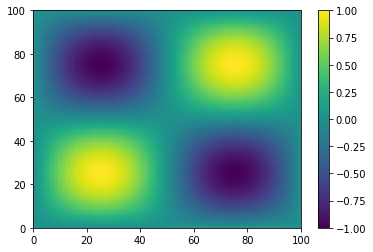

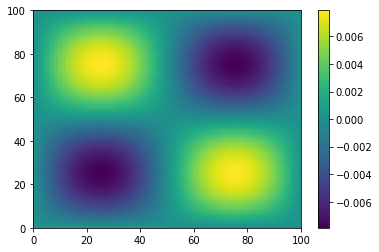

In [10]:
x, y = np.meshgrid(np.linspace(0, 2*np.pi, 100, endpoint=False), np.linspace(0, 2*np.pi, 100, endpoint=False))
u = np.sin(x)*np.sin(y)
plt.pcolor(u)
plt.colorbar()
plt.figure()


L = np.zeros_like(u)
laplas_7(u, L, h = 3*np.pi/100)
plt.pcolor(L)
plt.colorbar()

In [197]:
a = np.arange(16)
a = a.reshape(4,4)
print(a)
a[np.arange(4),:]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [ ]:
nb.set_num_threads(2)

@nb.njit('void(f8[:,::1],f8[:,::1],f8)', nogil=True, parallel=True)
def laplas_parallel(u, L, h):
    K, J = u.shape
    for n in nb.prange(0,K-2):
        k = (2*n)%(K-1)+1
        for j in range(1,J-1):
            L[k,j] = (u[(k+1),j]+u[(k-1),j]-4*u[k,j]+u[k,(j+1)]+u[k,(j-1)])


    
            
N, M = 10000,10000
u = np.random.rand(N,M)
L = np.zeros_like(u)
print('for + jit ', benchmark(laplas_parallel, n=5, args=(u, L, 1)))